# 경고 메세지 무시

In [0]:
import warnings
warnings.filterwarnings("ignore")

# 재생산성을 위해 시드 고정

In [0]:
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Conv2D, Add, BatchNormalization, concatenate

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

In [0]:
%tensorflow_version 1.x

In [0]:
import random
import numpy as np
import tensorflow as tf
np.random.seed(777)
random.seed(777)
tf.random.set_seed(777)

# 데이터 불러오기

In [4]:
import os
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
os.chdir('/gdrive/My Drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
# 디렉토리 변경
newPath='./데이콘 정리된데이터'
train_diff = np.load(newPath+"/full_train_diff.npy")

In [6]:
train_diff.shape

(76345, 40, 40, 13)

In [13]:
# # 강수량이 -9999인것 삭제(이미 되어져 있어서 shape그대로)
# train_diff = np.delete(train_diff, np.where(train_diff[:, :, :, -1] == -9999), axis=0)
# train_diff.shape

(76345, 40, 40, 13)

In [0]:
values = list(range(train_diff.shape[0]))

from sklearn.model_selection import train_test_split
train_num, test_num = train_test_split(values, test_size=0.025)

xTrain = train_diff[:,:,:,:-1][train_num]
yTrain = train_diff[:,:,:,-1][train_num]
xValid = train_diff[:,:,:,:-1][test_num]
yValid = train_diff[:,:,:,-1][test_num]

xTrain.shape, yTrain.shape, xValid.shape, yValid.shape

## train_diff를 image, surface, location, precipitation으로 나누기

In [0]:
train_diff_images = xTrain[:, :, :, :9]
train_diff_surface = xTrain[:, :, :, 9]
train_diff_location_diff = xTrain[:, :, :, 10:12]
train_diff_precipitation = xTrain[:, :, :, -1]
del xTrain

In [29]:
xValid_diff_images = xValid[:, :, :, :9]
xValid_diff_surface = xValid[:, :, :, 9]
xValid_diff_location_diff = xValid[:, :, :, 10:12]
xValid_diff_precipitation = xValid[:, :, :, -1]
del xValid
xValid_diff_location_diff.shape

(1909, 40, 40, 2)

In [10]:
train_diff_location_diff.shape

(74436, 40, 40, 2)

## 각각 scaling하기

In [11]:
# xtrain image Std scaling하기
mean = train_diff_images[:,:,:,:9].mean(axis=(0,1,2))
std = train_diff_images[:,:,:,:9].std(axis=(0,1,2))
train_diff_images[:,:,:,:9] = (train_diff_images[:,:,:,:9] - mean) / std
train_diff_images.shape

(74436, 40, 40, 9)

In [30]:
# xvalid image Std scaling하기
mean = xValid_diff_images[:,:,:,:9].mean(axis=(0,1,2))
std = xValid_diff_images[:,:,:,:9].std(axis=(0,1,2))
xValid_diff_images[:,:,:,:9] = (xValid_diff_images[:,:,:,:9] - mean) / std
xValid_diff_images.shape

(1909, 40, 40, 9)

In [0]:
# 지표 타입 변경 (300->3,200->2,...)
train_diff_surface = np.where(train_diff_surface >= 300, 2, np.where(train_diff_surface >= 200, 1, np.where(train_diff_surface >= 100, 3, train_diff_surface)))

In [0]:
# 지표 타입 변경 (300->3,200->2,...)
xValid_diff_surface = np.where(xValid_diff_surface >= 300, 2, np.where(xValid_diff_surface >= 200, 1, np.where(xValid_diff_surface >= 100, 3, xValid_diff_surface)))

In [0]:
xValid

In [34]:
train_diff_location_diff[:,:,:,:2].shape
xValid_diff_location_diff[:,:,:,:2].shape

(1909, 40, 40, 2)

## 다시 합치기

In [0]:
train_scaled = np.concatenate((train_diff_images, train_diff_surface.reshape(-1, 40, 40, 1), train_diff_location_diff, train_diff_precipitation.reshape(-1, 40, 40, 1)), axis=3)

In [0]:
xValid_scaled = np.concatenate((xValid_diff_images, xValid_diff_surface.reshape(-1, 40, 40, 1), xValid_diff_location_diff, xValid_diff_precipitation.reshape(-1, 40, 40, 1)), axis=3)

In [0]:
del train_diff_images, train_diff_location_diff,train_diff_surface,train_diff_precipitation

In [0]:
del xValid_diff_images, xValid_diff_location_diff,xValid_diff_surface,xValid_diff_precipitation

In [0]:
np.save('./데이콘 정리된데이터'+"/refinedTrain_diff.npy",train_scaled) #<-refinedTrain_diff 로 저장
#실수로 xValid랑 나누어저장함

In [18]:
train_scaled.shape # train_diff의 precitation이 다시 들어갔으니 다시 나누어야함...

(74436, 40, 40, 13)

In [39]:
xValid_scaled.shape

(1909, 40, 40, 13)

# test데이터로 diff만들어 처리하기(이미함)

In [0]:
xTest = np.load(newPath+'/test.npy')
xTest.shape

(2416, 40, 40, 14)

In [0]:
tempLen = xTest.shape[0]*xTest.shape[1]*xTest.shape[2]
tempLen #<- reshape용 임시 길이변수
tempTest = xTest.reshape(tempLen,xTest.shape[-1]) #<- (3865600,14) reshape하기
tempStack = np.hstack((tempTest[:,:10],(tempTest[:,10]-tempTest[:,12]).reshape(-1,1))) #location 빼서 더하기(위도)
tempStack.shape

(3865600, 11)

In [0]:
TestStacked = np.hstack((tempStack,(tempTest[:,11]-tempTest[:,13]).reshape(-1,1)))
TestStacked.shape

(3865600, 12)

In [0]:
Test_diff=TestStacked.reshape(xTest.shape[0],xTest.shape[1],xTest.shape[2],12)
Test_diff.shape

(2416, 40, 40, 12)

In [0]:
np.save("Test_diff.npy",Test_diff) #<-Test_diff 만들어서 저장하기

In [0]:
test_diff_images = Test_diff[:, :, :, :9]
test_diff_surface = Test_diff[:, :, :, 9]
test_diff_location_diff = Test_diff[:, :, : , 10:12] #<-앞 소문자로 바꿈 
test_diff_images.shape, test_diff_surface.shape


((2416, 40, 40, 9), (2416, 40, 40))

In [0]:
mean = test_diff_images[:,:,:,:9].mean(axis=(0,1,2))
std = test_diff_images[:,:,:,:9].std(axis=(0,1,2))
test_diff_images[:,:,:,:9] = (test_diff_images[:,:,:,:9] - mean) / std
test_diff_images.shape

In [0]:
test_diff_surface = np.where(test_diff_surface >= 300, 2, np.where(test_diff_surface >= 200, 1, np.where(test_diff_surface >= 100, 3, test_diff_surface)))

In [0]:
mean = test_diff_location_diff[:,:,:,:2].mean(axis=(0,1,2))
std = test_diff_location_diff[:,:,:,:2].std(axis=(0,1,2))
test_diff_location_diff[:,:,:,:2] = (test_diff_location_diff[:,:,:,:2] - mean) / std
test_diff_location_diff.shape

(2416, 40, 40, 2)

In [0]:
test_diff_images = Test_diff[:, :, :, :9]
# test_diff_surface = Test_diff[:, :, :, 9]
# test_diff_location_diff = Test_diff[:, :, : , 10:12] #<-앞 소문자로 바꿈 
# test_diff_images.shape, test_diff_surface.shape

In [0]:
test = np.concatenate((test_diff_images, test_diff_surface.reshape(-1, 40, 40, 1), # test_diff_location_diff = Test_diff[:, :, : , 10:12] #<-앞 소문자로 바꿈 
), axis=3)

In [0]:
np.save("test_refinedAll.npy",test) #<-Test_diff 만들어서 저장하기

In [0]:
test_images = test[:, :, :, :9]
test_surface = test[:, :, :, 9]
test_location = test[:, :, : , 10:14]

In [0]:
tempTest = xTest.reshape(tempLen,xTest.shape[-1]) #<- (3865600,14)
tempStack = np.hstack((tempTest[:,:10],(tempTest[:,10]-tempTest[:,12]).reshape(-1,1)))
tempStack.shape

# 학습용 이미지와 라벨로 '다시' 분리

In [19]:
image = train_scaled[:, :, :, :-1]
label = train_scaled[:, :, :, -1]

image.shape, label.shape
del train_scaled

((74436, 40, 40, 12), (74436, 40, 40))

In [0]:
xValid = xValid_scaled[:,:,:,:-1]
yValid = xValid_scaled[:,:,:,-1]

xValid.shape, yValid.shape
del xValid_scaled

"train_diff파일을 train_test_split을 한 뒤 xTrain을 scaling해줌"


"scaling한후 다시 합쳐서(train_scaled) image와 label로 나눔"


"image와 label로 학습 후 xValid,yValid로 테스트"


"테스트 후 scaling해둔 test_diff로 제출용 파일 만들기"

"xValid도 scaling~

# 평가 함수 정의

In [0]:
from sklearn.metrics import f1_score

def mae(y_true, y_pred) :
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    
    y_pred = y_pred.reshape(1, -1)[0]
    
    over_threshold = y_true >= 0.1
    
    return np.mean(np.abs(y_true[over_threshold] - y_pred[over_threshold]))

def fscore(y_true, y_pred):
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    
    y_pred = y_pred.reshape(1, -1)[0]
    
    remove_NAs = y_true >= 0
    
    y_true = np.where(y_true[remove_NAs] >= 0.1, 1, 0)
    
    y_pred = np.where(y_pred[remove_NAs] >= 0.1, 1, 0)
    
    return(f1_score(y_true, y_pred))

def maeOverFscore(y_true, y_pred):
    return mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07)

def fscore_keras(y_true, y_pred):
    score = tf.py_function(func=fscore, inp=[y_true, y_pred], Tout=tf.float32, name='fscore_keras')
    return score

def maeOverFscore_keras(y_true, y_pred):
    score = tf.py_function(func=maeOverFscore, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_mse') 
    return score

# 모델 정의

In [0]:
# 모델
def create_model():
    inputs=Input(xTrain.shape[1:])
    
    bn=BatchNormalization()(inputs)
    conv0=Conv2D(256, kernel_size=1, strides=1, padding='same', activation='relu')(bn)
    
    bn=BatchNormalization()(conv0)
    conv=Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu')(bn)
    concat=concatenate([conv0, conv], axis=3)
    
    bn=BatchNormalization()(concat)
    conv=Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(bn)
    concat=concatenate([concat, conv], axis=3)
        
    for i in range(5):
        bn=BatchNormalization()(concat)
        conv=Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(bn)
        concat=concatenate([concat, conv], axis=3)
    
    bn=BatchNormalization()(concat)
    outputs=Conv2D(1, kernel_size=1, strides=1, padding='same', activation='relu')(bn)
    
    model=Model(inputs=inputs, outputs=outputs)
    
    return model

In [25]:
Model = create_model()
Model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40, 40, 12)] 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 40, 40, 12)   48          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 40, 40, 256)  3328        batch_normalization[0][0]        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 40, 40, 256)  1024        conv2d[0][0]                     
______________________________________________________________________________________________

In [0]:
Model.compile(loss="mae", optimizer="adam", metrics=[maeOverFscore_keras, fscore_keras])

# 콜백 함수 정의

In [0]:
callbacks_list = [
                  tf.keras.callbacks.EarlyStopping(
                      monitor='val_maeOverFscore_keras',
                      patience=3,
                      restore_best_weights=True
                      ),
                  tf.keras.callbacks.ReduceLROnPlateau(
                      monitor='val_maeOverFscore_keras',
                      patience=3,
                      factor=0.8
                      )
                  ]

In [0]:
   #tf.keras.callbacks.ModelCheckpoint(
                  #    filepath='models/model' + str(model_number)+'.h5',
                  #    monitor='val_maeOverFscore_keras',
                  #    save_best_only=True
                  #    )

# 모델 훈련

In [0]:
#xTrain, yTrain이 image와 label로 바뀜
history = Model.fit(image, label, epochs=50, batch_size=128, validation_data=(xValid, yValid), callbacks=callbacks_list)


Epoch 1/50
 50/582 [=>............................] - ETA: 9:37 - loss: 0.0191 - maeOverFscore_keras: nan - fscore_keras: 0.0206

# 모델 저장

In [0]:
#Model.save('''경로 및 파일 명 설정''')
model_path = './모델저장폴더/'
file_name = '05-28 Resnet Scaled train_diff.h5'
Model.save(model_path+file_name)

# 평가 값 시각화

In [0]:
import matplotlib.pyplot as plt

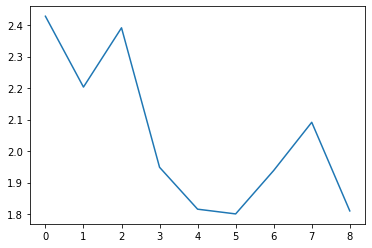

In [0]:
plt.plot(history.history['val_maeOverFscore_keras'])

# 테스트 데이터로 예측

In [0]:
# # 디렉토리 변경
# newPath='./데이콘 정리된데이터'
# train_diff = np.load(newPath+"/full_train_diff.npy")

In [0]:
xTest = np.load(newPath+'/test.npy')
xTest.shape

(2416, 40, 40, 14)

In [0]:
tempLen = xTest.shape[0]*xTest.shape[1]*xTest.shape[2]
tempLen
tempTest.shape
tempTest[:,13].shape

(3865600, 14)

In [0]:
tempTest = xTest.reshape(tempLen,xTest.shape[-1]) #<- (3865600,14)
tempStack = np.hstack((tempTest[:,:10],(tempTest[:,10]-tempTest[:,12]).reshape(-1,1)))
tempStack.shape

(3865600, 11)

In [0]:
TestStacked = np.hstack((tempStack,(tempTest[:,11]-tempTest[:,13]).reshape(-1,1)))
TestStacked.shape

(3865600, 12)

In [0]:
Test_diff=TestStacked.reshape(xTest.shape[0],xTest.shape[1],xTest.shape[2],12)
Test_diff.shape

(2416, 40, 40, 12)

In [0]:
pred = Model.predict(Test_diff)

In [0]:
del xTest

# 제출 파일 생성

In [0]:
import pandas as pd
submission = pd.read_csv('./Data/sample_submission.csv')

In [0]:
submission.iloc[:,1:] = pred.reshape(-1,1600)
submission

In [0]:
del pred

In [0]:
submission.to_csv('submission.csv', index=False)